In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import RobertaTokenizer, RobertaModel
from datasets import Dataset
import torch
import torch.nn as nn
from tqdm import tqdm
!pip install --quiet bertopic
# import warnings
# warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00:00:0100:01
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/test_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/dev_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/train_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/f

In [4]:
# Path to CSVs
train_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/train_sent_emo.csv')
dev_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/dev_sent_emo.csv')
test_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/test_sent_emo.csv')
print(train_df.columns)
train_df.head()



Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [3]:
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = tokenizer.model_max_length

def build_dynamic_context_inputs(df):
    inputs = []
    labels = []

    for dialog_id in df['Dialogue_ID'].unique():
        dialog = df[df['Dialogue_ID'] == dialog_id].sort_values('Utterance_ID')
        utterances = dialog['Utterance'].tolist()
        speakers = dialog['Speaker'].tolist()
        emotions = dialog['Emotion'].tolist()

        # Create speaker mapping for this dialogue
        unique_speakers = sorted(set(speakers))
        speaker_map = {name: f"speaker{i+1}" for i, name in enumerate(unique_speakers)}

        for idx in range(len(utterances)):
            context = []
            token_count = 0
            
            # Start from current utterance and go backward
            for i in range(idx, -1, -1):
                speaker_tag = speaker_map[speakers[i]]
                text_piece = f"{speaker_tag}: {utterances[i]}"
                tokens = tokenizer.tokenize(text_piece)
                token_count += len(tokens) + 1  # +1 for separator

                if token_count >= max_length:
                    break

                context.insert(0, text_piece)  # prepend so order is preserved

            input_text = " </s> ".join(context)
            inputs.append(input_text)
            labels.append(emotions[idx])

    return inputs, labels

train_inputs, train_labels = build_dynamic_context_inputs(train_df)
test_inputs, test_labels = build_dynamic_context_inputs(test_df)
dev_inputs, dev_labels = build_dynamic_context_inputs(dev_df)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
# Build new DataFrame from contextual inputs
label2id = {label: i for i, label in enumerate(sorted(set(train_labels)))} # Dict that maps each label to an integer
encoded_labels = [label2id[label] for label in train_labels]

# Now create the dataframe
data_dict = {
    "text": train_inputs,
    "label": encoded_labels
}
context_df = pd.DataFrame(data_dict)
train_dataset = Dataset.from_pandas(context_df)

# Function to tokenize the batch
def tokenize_batch(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True,
                     max_length=512,
                     return_attention_mask=True)

# Apply tokenizer
train_tokenized = train_dataset.map(tokenize_batch, batched=True, batch_size=32)
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# Now for the test set
test_label2id = {label: i for i, label in enumerate(sorted(set(test_labels)))} # Dict that maps each label to an integer
test_encoded_labels = [test_label2id[label] for label in test_labels]
test_data_dict = {
    "text": test_inputs,
    "label": test_encoded_labels
}
context_df = pd.DataFrame(test_data_dict)
test_dataset = Dataset.from_pandas(context_df)
test_tokenized = test_dataset.map(tokenize_batch, batched=True, batch_size=32)
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# dev set
dev_label2id = {label: i for i, label in enumerate(sorted(set(dev_labels)))} # Dict that maps each label to an integer
dev_encoded_labels = [dev_label2id[label] for label in dev_labels]
dev_data_dict = {
    "text": dev_inputs,
    "label": dev_encoded_labels
}
context_df = pd.DataFrame(dev_data_dict)
dev_dataset = Dataset.from_pandas(context_df)
dev_tokenized = dev_dataset.map(tokenize_batch, batched=True, batch_size=32)
dev_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# Create dataloaders for train and dev sets (and maybe also test set)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_tokenized, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_tokenized, batch_size=16)
test_loader = DataLoader(test_tokenized, batch_size=16)

Map:   0%|          | 0/9989 [00:00<?, ? examples/s]

Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

In [5]:
# Here I redefine the custom model class and reload the trained weights
class RobertaForEmotionClassification(nn.Module):
    def __init__(self, model, num_labels):
        super().__init__()
        self.roberta = model
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

# Instantiate model
num_labels = len(set(train_labels))  # e.g. 7 emotions
Full_model = RobertaForEmotionClassification(model, num_labels)

# Load the trained model for F1 score
model_path = "/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/best_emotion_model_5.pt"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

base_model = RobertaModel.from_pretrained("roberta-base")
Full_model = RobertaForEmotionClassification(base_model, num_labels)
Full_model.load_state_dict(checkpoint['model_state_dict'])
Full_model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForEmotionClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
          

<center>

# Finally we get to the Topic Modelling!! My initial approach here is to extract the embeddings from the [CLS] token, which is pretrained for classification tasks and is expected to capture a semantic representation of the input.
## I am performing a single forward pass so I can extract the embeddings

</center>

In [6]:
# Finally we get to the Topic Modelling
# I extract and combine the embeddings for each input - 
# I am performing a single forward pass so I can extract the embeddings

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Full_model.to(device)
Full_model.eval()

all_embeddings = []

with torch.no_grad():
    for loader in [train_loader]:
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = Full_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeds = outputs.last_hidden_state[:, 0, :]  # CLS token

            all_embeddings.append(cls_embeds.cpu())

# Combine all embeddings
embeddings_np = torch.cat(all_embeddings, dim=0).numpy()

100%|██████████| 625/625 [02:36<00:00,  4.00it/s]


<center>

## Perform Dimension Reduction and Clustering of the embeddings
## We retain 90 percent of the variance and then cluster the reduced embeddings into 7 clusters

</center>

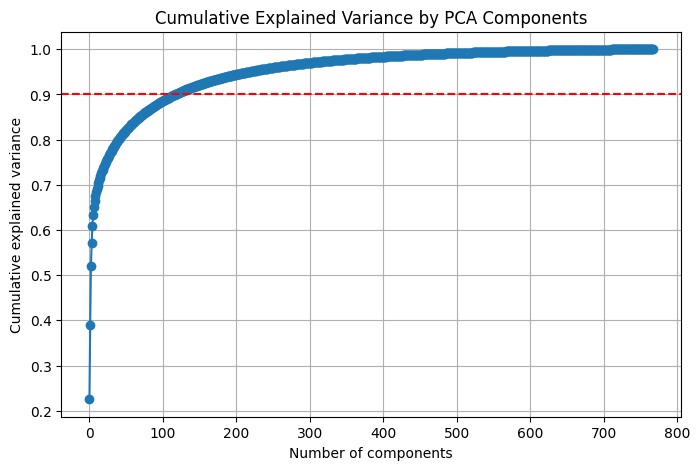

Number of components to retain 90% variance: 118
The reduced dimentionality of embeddings is 118


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

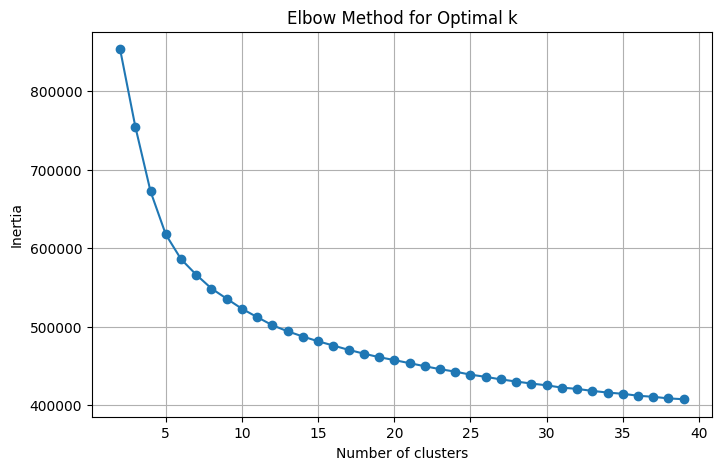

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
# Dimensionality reduction
pca = PCA().fit(embeddings_np)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()


# Find number of components to retain 90% variance
n_components_90 = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components_90}")

# Apply PCA with the chosen number of components
pca_90 = PCA(n_components=n_components_90)
embeddings_reduced = pca_90.fit_transform(embeddings_np)
print(f'The reduced dimentionality of embeddings is {embeddings_reduced.shape[1]}')
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
inertias = []
k_range = range(2, 40)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_reduced)  # use PCA-reduced embeddings
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# I am picking 7 clusters here just for the sake of convenience
# Since we have 7 labels in our data
best_k = 7
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(embeddings_reduced)

<center>

### Now I am trying to extract labels for clusters using TF-IDF so that the topics are hopefully interpretable. 

</center>

In [8]:
# Now I am assigning labels to clusters using TF-IDF so that the topics are hopefully interpretable. 
# This doesnt work very well - probebly because of the short context length for 
# each conversation. 
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import pandas as pd
import re

def remove_speaker_prefix(example):
    example['text'] = re.sub(r'speaker\d+:', '', example['text'], flags=re.IGNORECASE).strip()
    return example
test_dataset2 = test_dataset.map(remove_speaker_prefix)

cluster_to_utts = defaultdict(list)
# Group utterances by cluster
for utt, cluster_id in zip(test_dataset2['text'], clusters):
    cluster_to_utts[cluster_id].append(utt)

# Combine utterances in each cluster into a single "document"
cluster_documents = []
for cluster_id in sorted(cluster_to_utts.keys()):
    doc = " ".join(cluster_to_utts[cluster_id])
    cluster_documents.append(doc)

# Compute TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(cluster_documents)

# Get feature (word) names
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to store top words per cluster
top_words_per_cluster = {}

# For each cluster, get top-N words
top_n = 5  # number of top words per cluster
for cluster_id in range(len(cluster_documents)):
    tfidf_scores = tfidf_matrix[cluster_id].toarray().flatten()
    top_indices = tfidf_scores.argsort()[::-1][:top_n]
    top_words = [feature_names[i] for i in top_indices]
    top_words_per_cluster[cluster_id] = top_words

# Display results nicely
df = pd.DataFrame.from_dict(top_words_per_cluster, orient='index', columns=[f'Term {i+1}' for i in range(top_n)])
df.index.name = 'Cluster'
print(df)

Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

        Term 1 Term 2 Term 3 Term 4 Term 5
Cluster                                   
0           oh   know   yeah   okay   just
1           oh   know   just   okay   yeah
2           oh   know    hey   just   yeah
3           oh   okay   know   just   yeah
4           oh   okay   know   just   yeah
5           oh   know   okay   yeah    hey
6           oh   know   just   yeah   okay


<center>

## The above words seem to not be very emaningful. This may possibly be a limitation of the dataset itself given the short context and the nature of the conversations being had. But later I try a few other aproaches to modelling the topics in the text. 

## Below I do some visualisation

<center>

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


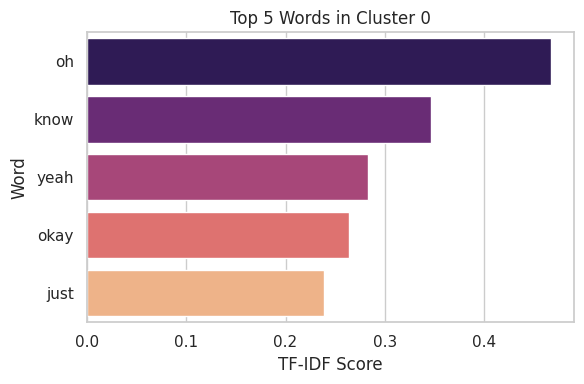

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


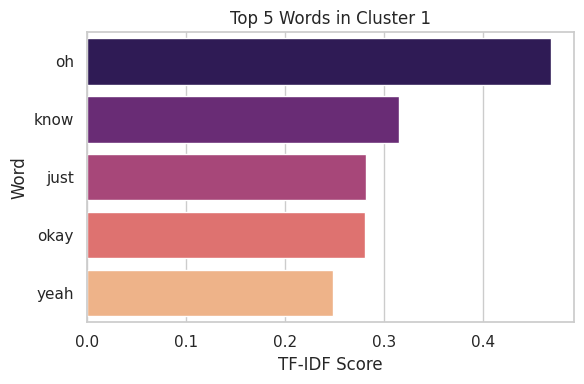

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


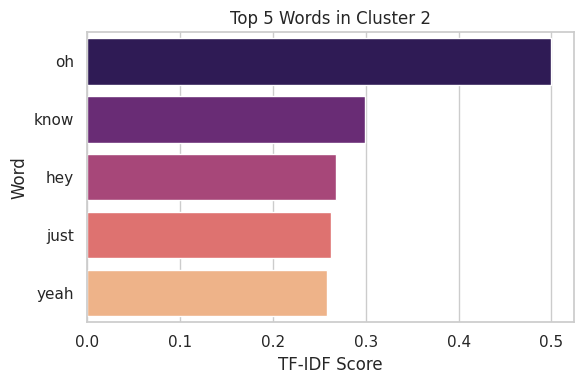

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


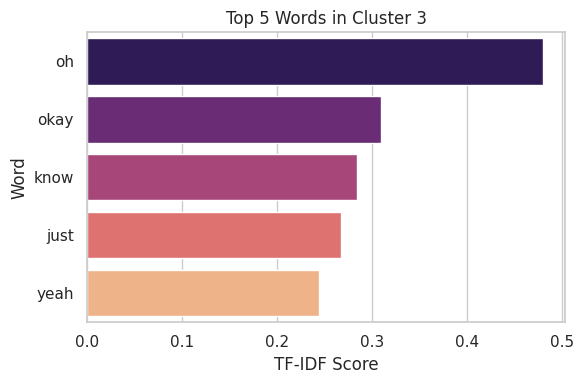

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


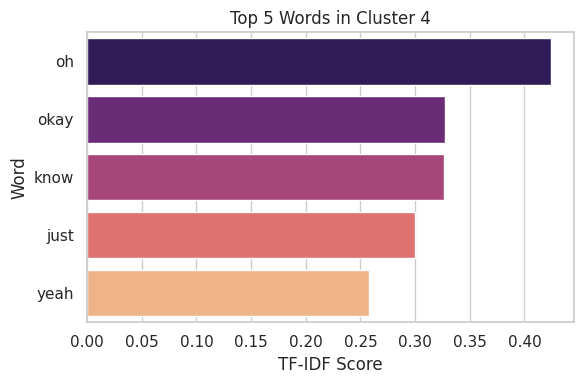

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


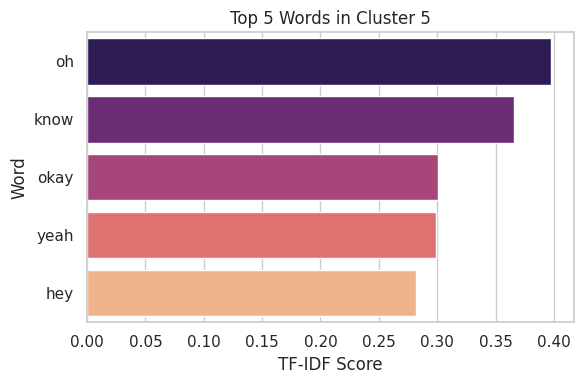

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


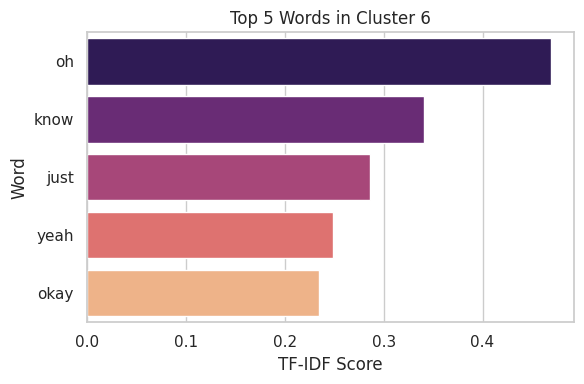

In [9]:
# 
import matplotlib.pyplot as plt
import seaborn as sns

# Set up for nicer plots
sns.set(style='whitegrid')
num_clusters = len(cluster_documents)
top_n = 5

# Plot barplot for each cluster
for cluster_id in range(num_clusters):
    tfidf_scores = tfidf_matrix[cluster_id].toarray().flatten()
    top_indices = tfidf_scores.argsort()[::-1][:top_n]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = tfidf_scores[top_indices]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=top_scores, y=top_words, palette="magma")
    plt.title(f"Top {top_n} Words in Cluster {cluster_id}")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

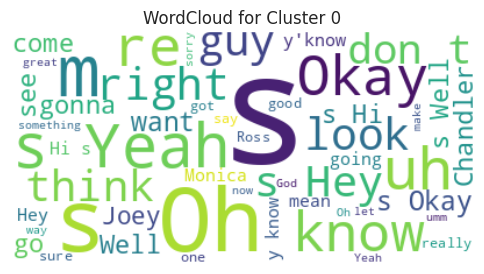

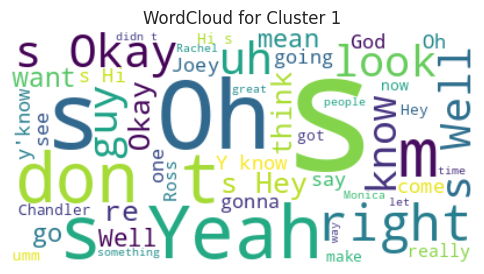

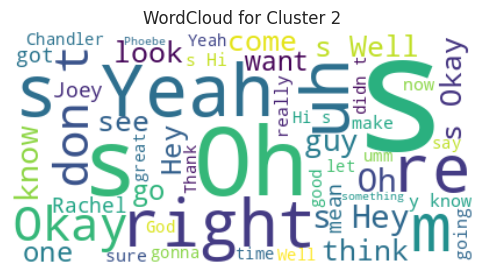

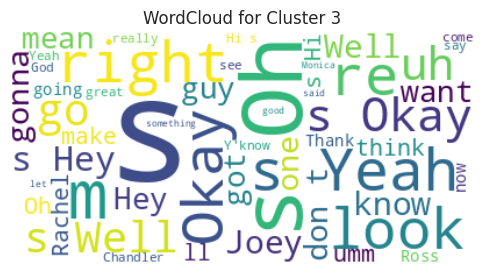

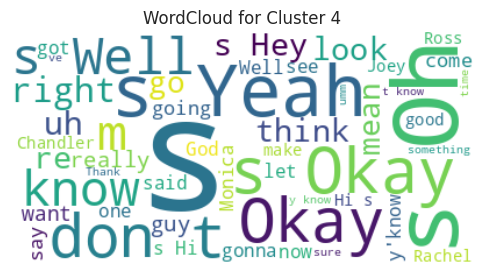

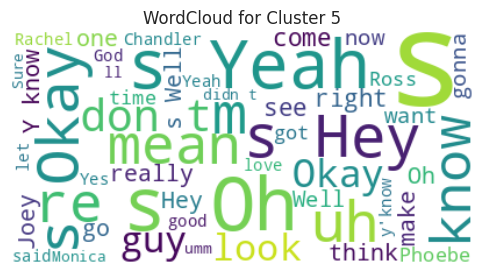

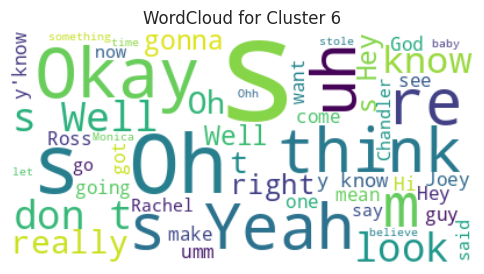

In [10]:
from wordcloud import WordCloud

for cluster_id in range(num_clusters):
    doc = cluster_documents[cluster_id]
    wordcloud = WordCloud(background_color='white', max_words=50).generate(doc)

    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for Cluster {cluster_id}")
    plt.show()

<center>

# **The above clusters did not seem to be very meaningful. I will try mean pooling the embeddings before clustering to see if that yields more meaningful results**

<center>

In [11]:
# Here I try mean pooling instead because the cls token embeddings 
# are not yielding very meaningful clusters

all_embeddings = []
with torch.no_grad():
    for loader in [train_loader]:
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = Full_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
            token_embeddings = outputs.last_hidden_state  # [batch, seq_len, hidden_dim]

            # This is where I perform the mean pooling instead of the cls extraction
            attention_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            masked_embeddings = token_embeddings * attention_mask_expanded
            sum_embeddings = masked_embeddings.sum(1)
            sum_mask = attention_mask_expanded.sum(1)

            mean_pooled = sum_embeddings / sum_mask.clamp(min=1e-9)
            all_embeddings.append(mean_pooled.cpu())

embeddings_np = torch.cat(all_embeddings, dim=0).numpy()


from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(embeddings_np)

# Compute cluster centroids
centroids = kmeans.cluster_centers_

# Find nearest utterances to each centroid
# (Assuming test_inputs contains the original text inputs in order)
cluster_to_utterances = {}

for cluster_idx in range(num_clusters):
    cluster_mask = (cluster_ids == cluster_idx)
    cluster_embeddings = embeddings_np[cluster_mask]

    # Calculate cosine similarity with the cluster centroid
    similarities = cosine_similarity([centroids[cluster_idx]], cluster_embeddings)[0]

    # Find the top-k closest utterances
    top_k = 5
    cluster_indices = np.where(cluster_mask)[0]
    top_indices = cluster_indices[np.argsort(similarities)[::-1][:top_k]]

    cluster_to_utterances[cluster_idx] = [train_inputs[i] for i in top_indices]

# View the results of the utterances clustered into topics
for cluster_id, utterances in cluster_to_utterances.items():
    print(f"\n--- Topic {cluster_id} ---")
    for utt in utterances:
        print("-", utt)

100%|██████████| 625/625 [02:35<00:00,  4.01it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



--- Topic 0 ---
- speaker1: Well, I-I-I'm done with this. You want anything Ross? Sports? International? Apartment listings?
- speaker1: Ok, I know this is gonna sound really stupid, but I feel that if I can do this, you know, if I can actually do my own laundry, there isn't anything I can't do.
- speaker2: Hey Mikey </s> speaker1: Hey P </s> speaker2: What are you doing? </s> speaker1: Setting rattraps </s> speaker2: To kill Bob?? </s> speaker1: No, no, to test his neck strength. </s> speaker2: No, Mike, I don't want to kill him!
- speaker1: Okay, yeah.  Triple A can pick us up.
- speaker2: I know it doesn't make much sense </s> speaker1: Much </s> speaker2: Look Chandler, it was instinct! Okay? I just went for it! </s> speaker1: So you risked your life, for a sandwich! </s> speaker2: I know it sounds crazy, but Chandler this is  the greatest sandwich in the world! </s> speaker1: So you didn't uh, choose Ross before me. </s> speaker2: No! I would never do that! You-you're like my bro

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


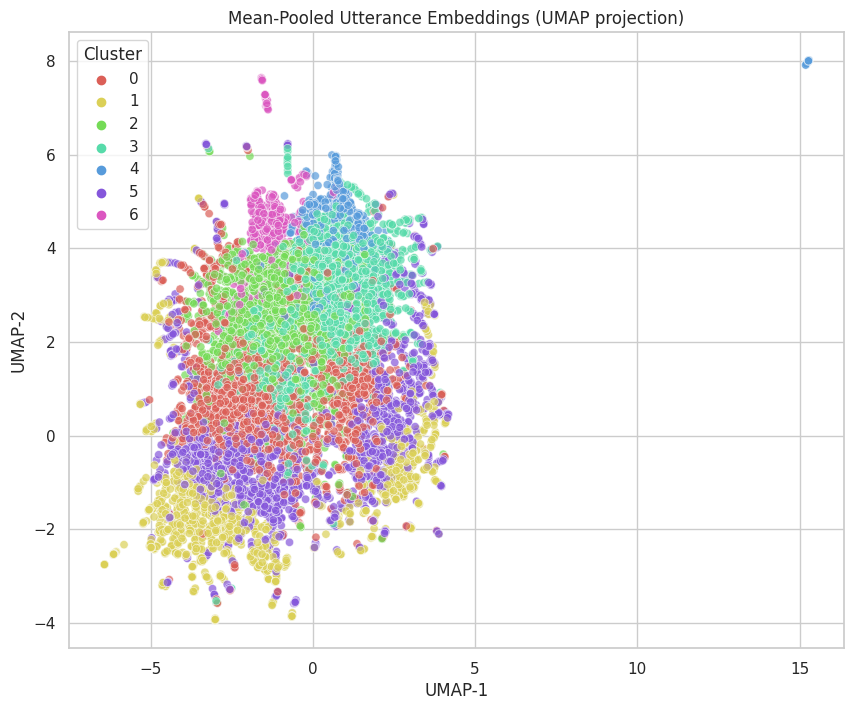

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

# Reduce to 2D
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embeddings_np)

# Plot
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hls", num_clusters)
sns.scatterplot(
    x=embedding_2d[:, 0], y=embedding_2d[:, 1],
    hue=cluster_ids,
    palette=palette,
    legend="full",
    alpha=0.7
)
plt.title("Mean-Pooled Utterance Embeddings (UMAP projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

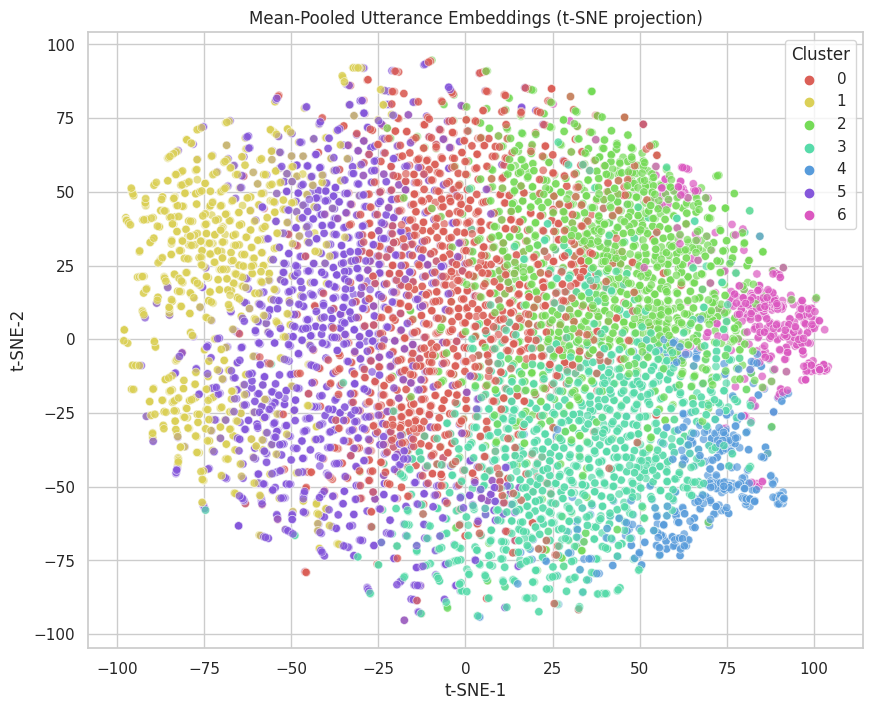

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embedding_2d = tsne.fit_transform(embeddings_np)

# Plot
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hls", num_clusters)
sns.scatterplot(
    x=embedding_2d[:, 0], y=embedding_2d[:, 1],
    hue=cluster_ids,
    palette=palette,
    legend="full",
    alpha=0.7
)
plt.title("Mean-Pooled Utterance Embeddings (t-SNE projection)")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

## Perhaps there is bit of structure/separation in the clusters, but not very convincing. There seems to be quite a bit of overlap

<center>
    
# **Now try the classic LDA for Topic Modelling**
## This is a very rough first attempt at LDA. Probably can be improved

</center>

In [1]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/train_sent_emo.csv')
texts = train_df['Utterance'].tolist()  

# 1. Convert to document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(texts)

# 2. Fit LDA model
num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# 3. Extract top words per topic
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[::-1][:no_top_words]
        top_words = [feature_names[i] for i in top_indices]
        topic_dict[f"Topic {topic_idx}"] = top_words
    return pd.DataFrame.from_dict(topic_dict, orient='index', columns=[f"Word {i+1}" for i in range(no_top_words)])

feature_names = vectorizer.get_feature_names_out()
topic_words_df = display_topics(lda_model, feature_names, no_top_words=5)
print(topic_words_df)

        Word 1    Word 2 Word 3 Word 4  Word 5
Topic 0   joey       don     ve   okay    room
Topic 1   okay      come  sorry   just  phoebe
Topic 2   yeah    really    yes    wow   thing
Topic 3    hey        uh    don  think    ross
Topic 4     oh       god     ll     hi   great
Topic 5   just       let     ok     ll    like
Topic 6   know     gonna    don   like    mean
Topic 7   look      love   sure     um   wanna
Topic 8  right     thank   said   want     ohh
Topic 9    got  chandler   wait     ah    whoa


In [15]:
topic_distributions = lda_model.transform(dtm)
assigned_topics = topic_distributions.argmax(axis=1)

# View a few example utterances and their topics
for i in range(5):
    print(f"Utterance: {texts[i]}")
    print(f"Assigned Topic: {assigned_topics[i]}")
    print("---")

Utterance: also I was the point person on my companys transition from the KL-5 to GR-6 system.
Assigned Topic: 8
---
Utterance: You mustve had your hands full.
Assigned Topic: 0
---
Utterance: That I did. That I did.
Assigned Topic: 1
---
Utterance: So lets talk a little bit about your duties.
Assigned Topic: 5
---
Utterance: My duties?  All right.
Assigned Topic: 5
---


<center>

## From the above topics and utterance assignments, this might have already worked a bit better than the previous approach. Perhaps with a further extension of context in the input data, this might be more meaningful. 

<center>

<center>

# **Try Topic Modelling using BERTopic**
# BERTopic is a topic modeling technique that combines transformer-based embeddings (e.g., Sentence-BERT)
# with clustering algorithms (e.g., HDBSCAN) to identify meaningful topics in text data.
# It generates document embeddings, which is may allow it to work well even with short texts like we have.
# The topics are then represented by interpretable keywords extracted using class-based TF-IDF (c-TF-IDF).

</center>

In [5]:
# Try using BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load embedding model on GPU
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")
topic_model = BERTopic(embedding_model=embedding_model,
                       language="english",
                       calculate_probabilities=True,
                       verbose=False)
# Fit the model
topics, probs = topic_model.fit_transform(train_df['Utterance'].tolist())
topic_model.reduce_topics(train_df['Utterance'].tolist(), nr_topics=7)

# 4. View top keywords per topic
topic_info = topic_model.get_topic_info()
print(topic_info.head())

   Topic  Count                     Name  \
0     -1   2861         -1_you_the_to_it   
1      0   5180        0_you_the_it_what   
2      1   1573      1_you_she_ross_joey   
3      2    222        2_can_you_do_that   
4      3    131  3_thank_thanks_here_you   

                                      Representation  \
0      [you, the, to, it, and, that, oh, me, in, we]   
1    [you, the, it, what, oh, to, that, no, hey, we]   
2  [you, she, ross, joey, her, and, to, the, chan...   
3  [can, you, do, that, it, one, help, money, fiv...   
4  [thank, thanks, here, you, wow, go, right, pro...   

                                 Representative_Docs  
0  [This-this, no, oh no, no-no-no, this is nott...  
1  [Oh my God! This is it!   I really hope its y...  
2  [Ross, I am telling you that she is using you ...  
3  [I cant do it!, Can't do it, can you?, You ca...  
4               [Thank you., Thank you., Thank you.]  


In [6]:
# Topic frequency bar chart
topic_model.visualize_barchart()

# # Topic similarity map
# topic_model.visualize_hierarchy()

# # Intertopic distance map (via UMAP)
# topic_model.visualize_topics()

In [7]:
# Print topic overview
topics_info = topic_model.get_topic_info()
for i in range(len(topics_info)):
    topic_id = topics_info.iloc[i]["Topic"]
    if topic_id == -1:
        continue  # Skip outliers
    print(f"Topic {topic_id}: {topics_info.iloc[i]['Representation']}")


# Show human-friendly summaries
for topic in topic_model.get_topics():
    if topic == -1:
        continue
    words = topic_model.get_topic(topic)
    keywords = [w for w, _ in words[:5]]
    print(f"Topic {topic}: {', '.join(keywords)}")

Topic 0: ['you', 'the', 'it', 'what', 'oh', 'to', 'that', 'no', 'hey', 'we']
Topic 1: ['you', 'she', 'ross', 'joey', 'her', 'and', 'to', 'the', 'chandler', 'that']
Topic 2: ['can', 'you', 'do', 'that', 'it', 'one', 'help', 'money', 'five', 'have']
Topic 3: ['thank', 'thanks', 'here', 'you', 'wow', 'go', 'right', 'problem', 'much', 'welcome']
Topic 4: ['bing', 'mr', 'occasional', 'aboard', 'binge', 'ette', 'ing', 'enjoyed', 'you', 'numbers']
Topic 5: ['bijan', 'men', 'for', 'of', 'man', 'slut', 'manly', 'also', 'check', 'kind']
Topic 0: you, the, it, what, oh
Topic 1: you, she, ross, joey, her
Topic 2: can, you, do, that, it
Topic 3: thank, thanks, here, you, wow
Topic 4: bing, mr, occasional, aboard, binge
Topic 5: bijan, men, for, of, man
